In [1]:
from sdcd import SDCD
import sdcd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.graph.GraphNode   import GraphNode
from causallearn.graph.GeneralGraph import GeneralGraph
from causallearn.utils.GraphUtils  import GraphUtils
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("encoded_clean_data3.csv")

df = df.iloc[:, 1:-17]
df = df.apply(pd.to_numeric, errors="coerce")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.apply(lambda col: col.fillna(col.mean()), axis=0)
df = df.dropna(axis=1, how="all")
df = df.dropna(axis=0, how="any")

In [3]:
def make_sdcd_tensors(X: torch.Tensor):
    n_samples, n_vars = X.shape
    mask_interventions = torch.ones((n_samples, n_vars), dtype=X.dtype, device=X.device)
    regimes            = torch.zeros((n_samples, 1),       dtype=X.dtype, device=X.device)
    return X, mask_interventions, regimes

In [ ]:
df1 = df.sample(frac=0.1, random_state=42)
X1 = torch.tensor(df1.values, dtype=torch.float32)

X1, mask_interventions, regimes = make_sdcd_tensors(X1) 
dataset1 = TensorDataset(X1, mask_interventions, regimes)

stage1_kwargs = dict(  # pre-filtering
    n_epochs        = 300,
    batch_size      = 512,
    learning_rate   = 3e-3,
    n_epochs_check  = 50,
    mask_threshold  = 0.2
)

stage2_kwargs = dict(  # main training
    n_epochs              = 1000,
    batch_size            = 512,
    learning_rate         = 3e-3,
    gamma_increment       = 0.002,
    gamma_schedule        = "linear",
    threshold             = 0.1,
    freeze_gamma_at_dag   = False,
    lambda_sparse         = 0.0005,
    n_epochs_check        = 20
)

model_kwargs = dict(  # model architecture
    num_layers              = 3,
    dim_hidden              = 256,
    dropout_rate            = 0.0,
    power_iteration_n_steps = 8
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SDCD(standard_scale=False)

model.train(
    dataset1,
    val_fraction    = 0.1,         
    stage1_kwargs   = stage1_kwargs,
    stage2_kwargs   = stage2_kwargs,
    model_kwargs    = model_kwargs,
    skip_masking    = False,
    warm_start      = True,
    device          = device,
    verbose         = True
)

# if hasattr(model, "val_losses"):
#     val_loss_log = pd.DataFrame({
#         "epoch": list(range(len(model.val_losses))),
#         "val_loss": model.val_losses
#     })
#     val_loss_log.to_csv("val_loss_log.csv", index=False)
#     print("✅ Validation loss log saved to val_loss_log.csv")
# else:
#     print("⚠️ val_losses not found in model. Cannot log.")

A_hat = model.get_adjacency_matrix() 

Epoch 0: loss=46411.13, gamma=0.00
Epoch 50: loss=2547.53, gamma=0.00
Epoch 100: loss=1723.93, gamma=0.00
Epoch 150: loss=1386.50, gamma=0.00
Epoch 200: loss=1180.49, gamma=0.00
Epoch 250: loss=1035.22, gamma=0.00
Fraction of possible edges in mask: 0.05536332179930796
Epoch 0: loss=44780.45, gamma=0.00
Epoch 20: loss=4631.68, gamma=0.04
Epoch 40: loss=2827.74, gamma=0.08
Epoch 60: loss=2157.10, gamma=0.12
Epoch 80: loss=1820.74, gamma=0.16
Epoch 100: loss=1649.68, gamma=0.20
Epoch 120: loss=1468.20, gamma=0.24
Epoch 140: loss=1378.73, gamma=0.28
Epoch 160: loss=1263.92, gamma=0.32
Epoch 180: loss=1180.16, gamma=0.36
Epoch 200: loss=1110.48, gamma=0.40
Epoch 220: loss=1067.80, gamma=0.44
Epoch 240: loss=1000.59, gamma=0.48
Epoch 260: loss=949.83, gamma=0.52
Epoch 280: loss=907.28, gamma=0.56
Epoch 300: loss=869.42, gamma=0.60
Epoch 320: loss=831.28, gamma=0.64
Epoch 340: loss=798.10, gamma=0.68
Epoch 360: loss=773.64, gamma=0.72
Epoch 380: loss=738.39, gamma=0.76
Epoch 400: loss=709.73

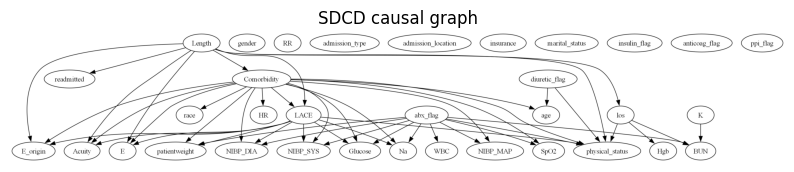

In [9]:
A = A_hat.copy()                       
cols = df1.columns.tolist()             

nodes = [GraphNode(name) for name in cols]     
G_cl  = GeneralGraph(nodes)

for i in range(len(cols)):
    for j in range(len(cols)):
        if A[i, j] != 0:                       # j → i
            G_cl.add_directed_edge(nodes[j], nodes[i])

pydot_graph = GraphUtils.to_pydot(G_cl, labels=cols)
pydot_graph.write_png("figures/sdcd_result.png")

img = plt.imread("figures/sdcd_result.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.title("SDCD causal graph")
plt.show()

20 variables

valiaation for loss

In [36]:
df2 = df.sample(frac=0.1, random_state=42)
features2 = [
    "physical_status", "Length", "LACE", "Comorbidity", "age", "BUN",
    "NIBP_MAP", "E_origin", "WBC", "HR", "admission_location", "insurance",
    "NIBP_DIA", "Acuity", "Hgb", "NIBP_SYS", "Glucose", "SpO2", "readmitted"
]

df2 = df2[features2]
X2 = torch.tensor(df2.values, dtype=torch.float32)

X2, mask_interventions, regimes = make_sdcd_tensors(X2) 
dataset2 = TensorDataset(X2, mask_interventions, regimes)

stage1_kwargs = dict(            # pre filter
    n_epochs        = 300,       
    batch_size      = 1024,      
    learning_rate   = 2e-3,
    n_epochs_check  = 50,        
    mask_threshold  = 0.2       
)

stage2_kwargs = dict(            # main train
    n_epochs            = 800,   
    batch_size          = 1024,
    learning_rate       = 2e-3,
    gamma_increment     = 0.01,  # for regression
    gamma_schedule      = "linear",
    threshold           = 0.1,  
    freeze_gamma_at_dag = True,
    n_epochs_check      = 100
)

model_kwargs = dict(             # model structure
    num_layers             = 2,   
    dim_hidden             = 32,
    dropout_rate            = 0.2,  
    power_iteration_n_steps = 8    
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2 = SDCD(standard_scale=False)                
model2.train(
    dataset2,
    val_fraction = 0.1,                           
    stage1_kwargs=stage1_kwargs,
    stage2_kwargs=stage2_kwargs,
    model_kwargs=model_kwargs,
    skip_masking=False,                           # phase 1
    warm_start=True,                              
    device=device,
    verbose=True                                  
)

A_hat2 = model2.get_adjacency_matrix()

Epoch 0: loss=193553.46, gamma=0.00
Epoch 50: loss=21018.33, gamma=0.00
Epoch 100: loss=13143.21, gamma=0.00
Epoch 150: loss=10138.53, gamma=0.00
Epoch 200: loss=8119.88, gamma=0.00
Epoch 250: loss=6103.51, gamma=0.00
Fraction of possible edges in mask: 0.10526315789473684
Epoch 0: loss=294022.89, gamma=0.00
Epoch 100: loss=16535.38, gamma=1.00
Epoch 200: loss=10086.42, gamma=2.00
Epoch 300: loss=7378.93, gamma=2.40
Epoch 400: loss=5339.15, gamma=2.40
Epoch 500: loss=4051.35, gamma=2.40
Epoch 600: loss=3663.59, gamma=2.40
Epoch 700: loss=2884.39, gamma=2.40
Finished training in 526.2118833065033 seconds.


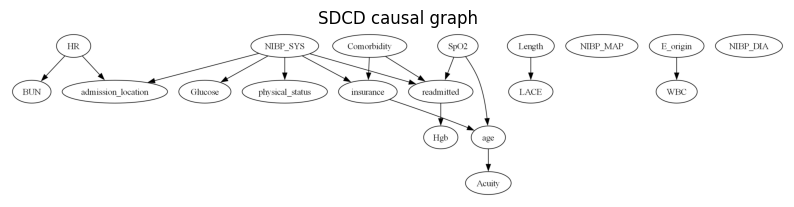

In [37]:
A2 = A_hat2.copy()                       
cols2 = df2.columns.tolist()             

nodes = [GraphNode(name) for name in cols2]     
G_cl  = GeneralGraph(nodes)

for i in range(len(cols2)):
    for j in range(len(cols2)):
        if A[i, j] != 0:                       # j → i
            G_cl.add_directed_edge(nodes[j], nodes[i])

pydot_graph = GraphUtils.to_pydot(G_cl, labels=cols2)
pydot_graph.write_png("figures/sdcd_result2.png")

img = plt.imread("figures/sdcd_result2.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.title("SDCD causal graph")
plt.show()

10 variables

In [48]:
df3 = df.sample(frac=0.1, random_state=42)
features3 = [
    "physical_status", "Length", "LACE", "Comorbidity", "age", "BUN",
    "NIBP_MAP", "E_origin", "WBC", "readmitted"
]

df3 = df3[features3]
# df3 = pd.DataFrame(StandardScaler().fit_transform(df3), columns=df3.columns)
X3 = torch.tensor(df3.values, dtype=torch.float32)

X3, mask_interventions, regimes = make_sdcd_tensors(X3) 
dataset3 = TensorDataset(X3, mask_interventions, regimes)

stage1_kwargs = dict(            # pre filter
    n_epochs        = 400,       
    batch_size      = 512,      
    learning_rate   = 1e-3,
    n_epochs_check  = 100,        
    mask_threshold  = 0.05       
)

stage2_kwargs = dict(            # main train
    n_epochs            = 800,   
    batch_size          = 512,
    learning_rate       = 1e-3,
    gamma_increment     = 0.005,  # for regression
    gamma_schedule      = "linear",
    threshold           = 0.02,  
    freeze_gamma_at_dag = True,
    n_epochs_check      = 100
)

model_kwargs = dict(             # model structure
    num_layers             = 2,   
    dim_hidden             = 32,
    dropout_rate            = 0.2,  
    power_iteration_n_steps = 8    
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model3 = SDCD(standard_scale=False)                
model3.train(
    dataset3,
    val_fraction = 0.1,                           
    stage1_kwargs=stage1_kwargs,
    stage2_kwargs=stage2_kwargs,
    model_kwargs=model_kwargs,
    skip_masking=False,                           # phase 1
    warm_start=True,                              
    device=device,
    verbose=True                                  
)

A_hat3 = model3.get_adjacency_matrix()

Epoch 0: loss=312428.94, gamma=0.00
Epoch 100: loss=17131.06, gamma=0.00
Epoch 200: loss=9906.88, gamma=0.00
Epoch 300: loss=6334.07, gamma=0.00
Fraction of possible edges in mask: 0.66
Epoch 0: loss=191224.47, gamma=0.00
Epoch 100: loss=12849.01, gamma=0.50
Epoch 200: loss=7368.55, gamma=1.00
Epoch 300: loss=4878.94, gamma=1.50
Epoch 400: loss=3340.76, gamma=2.00
Epoch 500: loss=2369.81, gamma=2.50
Epoch 600: loss=1751.10, gamma=3.00
Epoch 700: loss=1317.27, gamma=3.50
Finished training in 135.9043173789978 seconds.


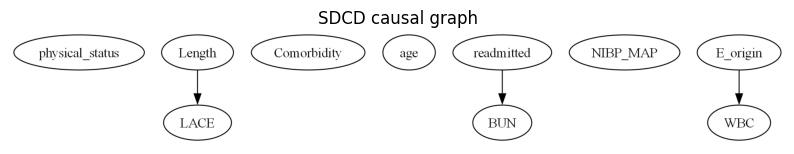

In [49]:
A3 = A_hat3.copy()                       
cols3 = df3.columns.tolist()             

nodes = [GraphNode(name) for name in cols3]     
G_cl  = GeneralGraph(nodes)

for i in range(len(cols3)):
    for j in range(len(cols3)):
        if A[i, j] != 0:                       # j → i
            G_cl.add_directed_edge(nodes[j], nodes[i])

pydot_graph = GraphUtils.to_pydot(G_cl, labels=cols3)
pydot_graph.write_png("figures/sdcd_result3.png")

img = plt.imread("figures/sdcd_result3.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.title("SDCD causal graph")
plt.show()

6 variables

In [58]:
df4 = df.sample(frac=0.1, random_state=42)
features4 = [
    "physical_status", "Length", "LACE", "Comorbidity", "age", "readmitted"
]

df4 = df4[features4]
X4 = torch.tensor(df4.values, dtype=torch.float32)

X4, mask_interventions, regimes = make_sdcd_tensors(X4) 
dataset4 = TensorDataset(X4, mask_interventions, regimes)

stage1_kwargs = dict(            # pre filter
    n_epochs        = 600,       
    batch_size      = 512,      
    learning_rate   = 1e-3,
    n_epochs_check  = 100,        
    mask_threshold  = 0.005       
)

stage2_kwargs = dict(            # main train
    n_epochs            = 800,   
    batch_size          = 512,
    learning_rate       = 1e-3,
    gamma_increment     = 0.005,  # for regression
    gamma_schedule      = "linear",
    threshold           = 0.01,  
    freeze_gamma_at_dag = True,
    n_epochs_check      = 100
)

model_kwargs = dict(             # model structure
    num_layers             = 2,   
    dim_hidden             = 64,
    dropout_rate            = 0.1,  
    power_iteration_n_steps = 15    
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model4 = SDCD(standard_scale=False)                
model4.train(
    dataset4,
    val_fraction = 0.1,                           
    stage1_kwargs=stage1_kwargs,
    stage2_kwargs=stage2_kwargs,
    model_kwargs=model_kwargs,
    skip_masking=False,                           # phase 1
    warm_start=True,                              
    device=device,
    verbose=True                                  
)

A_hat4 = model4.get_adjacency_matrix()

Epoch 0: loss=185881.80, gamma=0.00
Epoch 100: loss=9355.78, gamma=0.00
Epoch 200: loss=5435.09, gamma=0.00
Epoch 300: loss=3603.62, gamma=0.00
Epoch 400: loss=2489.16, gamma=0.00
Epoch 500: loss=1780.51, gamma=0.00
Fraction of possible edges in mask: 0.6388888888888888
Epoch 0: loss=133555.75, gamma=0.00
Epoch 100: loss=8080.10, gamma=0.50
Epoch 200: loss=4550.52, gamma=1.00
Epoch 300: loss=2990.52, gamma=1.50
Epoch 400: loss=2039.42, gamma=2.00
Epoch 500: loss=1476.99, gamma=2.40
Epoch 600: loss=1064.97, gamma=2.40
Epoch 700: loss=804.26, gamma=2.40
Finished training in 186.48309469223022 seconds.


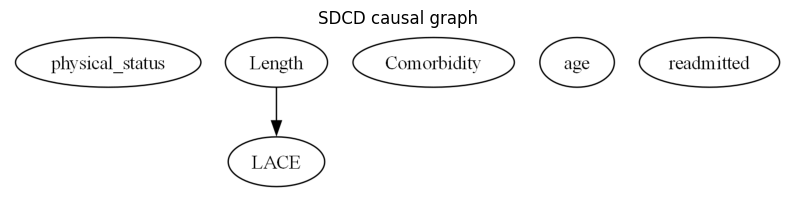

In [59]:
A4 = A_hat4.copy()                       
cols4 = df4.columns.tolist()             

nodes = [GraphNode(name) for name in cols4]     
G_cl  = GeneralGraph(nodes)

for i in range(len(cols4)):
    for j in range(len(cols4)):
        if A[i, j] != 0:                       # j → i
            G_cl.add_directed_edge(nodes[j], nodes[i])

pydot_graph = GraphUtils.to_pydot(G_cl, labels=cols4)
pydot_graph.write_png("figures/sdcd_result4.png")

img = plt.imread("figures/sdcd_result4.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.title("SDCD causal graph")
plt.show()

1.Non-identifiability under purely observational data  
Without interventional data, the direction of causality between two variables cannot be uniquely identified.  
2.Over-conservative structure filtering  
During Stage 1, SDCD applies L1 sparsity and thresholding to select candidate edges, it may prematurely discard important edges. Even with relaxed settings, the masking stage may prune away causal signals.